### Librerías

In [1]:
import pandas as pd
import numpy as np
import bcchapi
from datetime import timedelta
from datetime import datetime
import re
import xlrd
import openpyxl
import os
import pyodbc

### API BDE

In [2]:
siete = bcchapi.Siete("pbustamante@vectorcapital.cl", "Vector.2025")
fecha_hoy = datetime.today().strftime('%Y-%m-%d')

## EURO
df_euro_obs = siete.cuadro(
series=["F072.CLP.EUR.N.O.D"],
nombres = ["euro"],
desde="2025-01-01",
hasta=fecha_hoy)

df_euro_obs = df_euro_obs.reset_index()
df_euro_obs.columns = ['Fecha', 'Euro TC']
df_euro_obs["Fecha"] = pd.to_datetime(df_euro_obs["Fecha"]).dt.strftime("%d-%m-%Y")

### USD
df_dolar_obs = siete.cuadro(
series=["F073.TCO.PRE.Z.D"],
nombres = ["dolar"],
desde="2025-01-01",
hasta=fecha_hoy)
df_dolar_obs = df_dolar_obs.reset_index()
df_dolar_obs.columns = ['Fecha', 'Dolar TC']
df_dolar_obs["Fecha"] = pd.to_datetime(df_dolar_obs["Fecha"]).dt.strftime("%d-%m-%Y")

### FBICE

In [3]:
def extraer_año_desde_encabezado_BICE(texto_columna):
    """Extrae el año desde el texto del encabezado (antes del símbolo '|')"""
    before_pipe = re.split(r'\|', texto_columna)[0].strip()
    match = re.search(r'\b(\d{4})\b', before_pipe)
    return match.group(1) if match else ""

def cargar_cartola_bice(ruta_archivo, tipo_mon='clp', df_euro_obs=None):
    df = pd.read_excel(ruta_archivo)
    text = df.columns[0]
    year = extraer_año_desde_encabezado_BICE(text)
    
    # CLEAN ENTRADA y SALIDA
    df = df.iloc[9:]
    df.columns = df.iloc[0]
    df = df.iloc[2:].reset_index(drop=True)
    first_empty_index = df[df.isnull().all(axis=1)].index.min() # SALIDA
    if pd.notna(first_empty_index):
        df = df.iloc[:first_empty_index]
    # Fix fecha (completar y agregar año) y formatear dd-mm-yyyy; sacar col saldo contable
    df["Fecha"] = df["Fecha"].replace("-", pd.NA).ffill()
    df["Fecha"] = df["Fecha"].astype(str).str.strip() + "-" + year
    df["Fecha"] = pd.to_datetime(df["Fecha"], format="%d-%m-%Y", errors="coerce")
    df["Fecha"] = df["Fecha"].dt.strftime("%d-%m-%Y")
    if 'Saldo Contable' in df.columns:
        del df['Saldo Contable']
    # Si tipo_mon = 'eur', unir con tipo de cambio y convertir
    if tipo_mon.lower() == 'eur':
        if df_euro_obs is None:
            raise ValueError("Debe proporcionar df_euro_obs cuando tipo_mon es 'eur'")

        df = pd.merge(df, df_euro_obs, how='left', on='Fecha')

        # a numéricos y nuevos campos
        df['Cargos'] = pd.to_numeric(df['Cargos'], errors='coerce')
        df['Abonos'] = pd.to_numeric(df['Abonos'], errors='coerce')
        df['Euro TC'] = pd.to_numeric(df['Euro TC'], errors='coerce')
        df['Cargos Moneda de Origen'] = df['Cargos'] / df['Euro TC']
        df['Abono Moneda de Origen'] = df['Abonos'] / df['Euro TC']

    return df

### CARTOLAS

In [4]:
ruta_dir = r"Y:\Cartolas bancarias Contabilidad\2025\Mayo 2025\BICE\BICE 01-35659-3"
archivos = os.listdir(ruta_dir)
archivos_xlsx = [f for f in archivos if f.lower().endswith('.xlsx') and os.path.isfile(os.path.join(ruta_dir, f))]

dfs = []
for archivo in archivos_xlsx:
    ruta_archivo = os.path.join(ruta_dir, archivo)
    df = cargar_cartola_bice(ruta_archivo, tipo_mon='clp')
    dfs.append(df)

cartola_clp_RACIONAL = pd.concat(dfs, ignore_index=True)

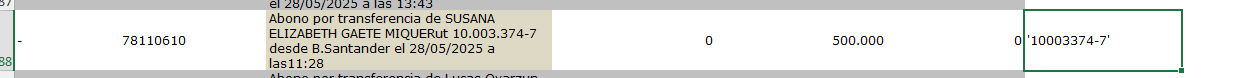

In [5]:
df_to_rut = cartola_clp_RACIONAL

# General
def extraer_rut(texto, n=1):
    """
    Extrae el n-ésimo RUT chileno del texto (por defecto el primero).
    Si no encuentra, retorna None.
    """
    # Busca todos los RUTs con 7 u 8 dígitos, guion y dígito/K
    ruts = re.findall(r'(\d{7,8}-[0-9Kk])', texto.replace('.', ''))
    if len(ruts) >= n:
        return ruts[n-1].upper()
    return None

# Ejemplo: para extraer el primer RUT
df_to_rut['IDENTIFICADOR'] = df_to_rut['Descripción'].apply(lambda x: extraer_rut(str(x), n=1))

# Extrae el RUT desde cualquier parte de la descripción
df_to_rut['IDENTIFICADOR'] = df_to_rut['Descripción'].apply(lambda x: extraer_rut(str(x)))

# Excepción
cond_excepcional = df_to_rut['Descripción'].str.contains(r'^Transf\. via Internet a cuenta .*desde VECTOR CAPITAL CORREDORES DE BOLSA SPA', regex=True)
df_to_rut.loc[cond_excepcional, 'IDENTIFICADOR'] = '076513680-6'

# Excepción
cond_excepcional = df_to_rut['Descripción'].str.contains(r'^Transf\. via Internet a cuenta .*desde VECTOR CAPITAL CORREDORES DE BOLSA SPA', regex=True)
df_to_rut.loc[cond_excepcional, 'IDENTIFICADOR'] = '076513680-6'
df_to_rut['IDENTIFICADOR'] = df_to_rut['IDENTIFICADOR'].str.replace('.', '', regex=False)

## Extraer hora depósito para el match con dashboard RC
def extraer_fecha_hora(texto):
    match = re.search(r'(\d{2}/\d{2}/\d{4})\s*a\s*las\s*(\d{2}:\d{2})', str(texto))
    if match:
        return f"{match.group(1)} {match.group(2)}"
    return None

df_to_rut['Fecha_transferencia'] = df_to_rut['Descripción'].apply(extraer_fecha_hora)
df_to_rut['Fecha_transferencia'] = pd.to_datetime(df_to_rut['Fecha_transferencia'], format='%d/%m/%Y %H:%M')
df_to_rut['Fecha_transferencia'] = df_to_rut['Fecha_transferencia'].dt.strftime('%d-%m-%Y %H:%M')

Debug

In [6]:
df_to_rut[df_to_rut['IDENTIFICADOR'] == '10003374-7'] 

9,Fecha,Documento,Descripción,Cargos,Abonos,IDENTIFICADOR,Fecha_transferencia
6844,05-05-2025,62450718,Abono por transferencia de SUSANA ELIZABETH GA...,0,280000,10003374-7,05-05-2025 10:22
10867,09-05-2025,65948282,Abono por transferencia de SUSANA ELIZABETH GA...,0,320000,10003374-7,09-05-2025 10:20
11015,09-05-2025,65880325,Abono por transferencia de SUSANA ELIZABETH GA...,0,1000000,10003374-7,09-05-2025 08:52
25360,28-05-2025,78110610,Abono por transferencia de SUSANA ELIZABETH GA...,0,500000,10003374-7,28-05-2025 11:28


### QRY

In [7]:
F_i  = '2025-04-29'
F    = '2025-06-02' 

query_universal = {

        'query_APORET': f"""
        SELECT 
               CARGO_ABONO, 
               NUM_CUENTA, 
               IDENTIFICADOR,
               NOMBRE_CLI, 
               COD_MOV, 
               DSC_MOV_CAJA, 
               FECHA_MOVIMIENTO,
               FECHA_LIQUIDACION, 
               MONTO, 
               NOMBRE_ASESOR, 
               TIPO_CAJA,
               MOV_AUTOMATICO,
               OBS_MOV_CAJA

        FROM [Capitaria].[dbo].[MOV_CAJA_CLI_JGG]
        WHERE COD_MOV IN (
            'APO_PAT',
            'APO_PAT_AT',
            'APO_PAT_BT',
            'APO_PAT_LI',
            'APO_PAT_RC'
            )
        AND FECHA_MOVIMIENTO BETWEEN CONVERT(datetime, '{F_i}', 120) AND CONVERT(datetime, '{F}', 120)
        """
}

conn = pyodbc.connect('DRIVER={SQL Server};SERVER=tcp:mi-sql-prd-002.5bf1e89c8cf2.database.windows.net;DATABASE=capitaria;UID=pablobustamante;PWD=S3cur3!PassPB5sta#2024')
df_APORET_detalle = pd.read_sql(query_universal['query_APORET'], conn)
conn.close()

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_10600\789851610.py:35: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_APORET_detalle = pd.read_sql(query_universal['query_APORET'], conn)


In [8]:
## FILTRAR CARTOLA
# Filtrar solo depósitos (Abonos > 0) y que IDENTIFICADOR no sea vacío ni nulo
df_to_rut = df_to_rut[(df_to_rut['Abonos'] > 0) & (df_to_rut['IDENTIFICADOR'].notna()) & (df_to_rut['IDENTIFICADOR'].str.strip() != '')]

# Asegura que las fechas sean datetime
df_to_rut['Fecha'] = pd.to_datetime(df_to_rut['Fecha'], format='%d-%m-%Y', errors='coerce')
df_APORET_detalle['FECHA_MOVIMIENTO'] = pd.to_datetime(df_APORET_detalle['FECHA_MOVIMIENTO'], errors='coerce')

# Ordena ambos DataFrames por IDENTIFICADOR, MONTO/Abonos y fecha
df_to_rut = df_to_rut.sort_values(['IDENTIFICADOR', 'Abonos', 'Fecha'])
df_APORET_detalle = df_APORET_detalle.sort_values(['IDENTIFICADOR', 'MONTO', 'FECHA_MOVIMIENTO'])

# Normaliza los montos a float y luego a int para evitar diferencias por decimales
df_to_rut['Abonos'] = pd.to_numeric(df_to_rut['Abonos'], errors='coerce').fillna(0).astype(int)
df_APORET_detalle['MONTO'] = pd.to_numeric(df_APORET_detalle['MONTO'], errors='coerce').fillna(0).astype(int)

# ---- Rut k to K
df_to_rut['IDENTIFICADOR'] = df_to_rut['IDENTIFICADOR'].str.upper()
df_APORET_detalle['IDENTIFICADOR'] = df_APORET_detalle['IDENTIFICADOR'].str.upper()

# Ahora crea la clave
df_to_rut['clave'] = df_to_rut['IDENTIFICADOR'].astype(str) + '_' + df_to_rut['Abonos'].astype(str)
df_APORET_detalle['clave'] = df_APORET_detalle['IDENTIFICADOR'].astype(str) + '_' + df_APORET_detalle['MONTO'].astype(str)

# mod
df_to_rut = df_to_rut.reset_index().rename(columns={'index': 'idx_cartola'})


# Para cada fila de df_to_rut, busca el match más cercano en fecha en df_APORET_detalle
resultados = []
usados = set()

for idx, row in df_to_rut.iterrows():
    candidatos = df_APORET_detalle[df_APORET_detalle['clave'] == row['clave']]
    if not candidatos.empty:
        # Calcula la diferencia absoluta de días
        candidatos = candidatos.assign(diff_days=(candidatos['FECHA_MOVIMIENTO'] - row['Fecha']).abs())
        # Elige el más cercano que no haya sido usado
        candidatos = candidatos[~candidatos.index.isin(usados)]
        if not candidatos.empty:
            elegido = candidatos.loc[candidatos['diff_days'].idxmin()]
            usados.add(elegido.name)
            merged_row = {**row, **elegido}
            resultados.append(merged_row)
        else:
            # No hay candidatos disponibles (ya usados)
            merged_row = {**row}
            for col in df_APORET_detalle.columns:
                if col not in merged_row:
                    merged_row[col] = np.nan
            resultados.append(merged_row)
    else:
        # No hay candidatos
        merged_row = {**row}
        for col in df_APORET_detalle.columns:
            if col not in merged_row:
                merged_row[col] = np.nan
        resultados.append(merged_row)

df_match = pd.DataFrame(resultados)

# ---- Solo dejar movimientos realmente matcheados (ambos lados tienen datos)
df_match = df_match[df_match['MONTO'].notna()]
# No match en cartola: los que no lograron match en GPI
no_match_cartola = df_to_rut[~df_to_rut['idx_cartola'].isin(df_match['idx_cartola'])]

# No match en APORET (los que no fueron usados)
no_match_aporet = df_APORET_detalle[~df_APORET_detalle.index.isin(usados)]

"""# Exporta a Excel
with pd.ExcelWriter('Temporal/ViernesCartolaGPI_realmatch10.xlsx') as writer:
    df_match.to_excel(writer, sheet_name='Match', index=False)
    df_to_rut.to_excel(writer, sheet_name='Cartola', index=False)
    df_APORET_detalle.to_excel(writer, sheet_name='GPI', index=False)
    no_match_cartola.to_excel(writer, sheet_name='No_Match_CARTOLA', index=False)
    no_match_aporet.to_excel(writer, sheet_name='No_Match_APORET', index=False)"""

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_10600\407170479.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_rut['Fecha'] = pd.to_datetime(df_to_rut['Fecha'], format='%d-%m-%Y', errors='coerce')


"# Exporta a Excel\nwith pd.ExcelWriter('Temporal/ViernesCartolaGPI_realmatch10.xlsx') as writer:\n    df_match.to_excel(writer, sheet_name='Match', index=False)\n    df_to_rut.to_excel(writer, sheet_name='Cartola', index=False)\n    df_APORET_detalle.to_excel(writer, sheet_name='GPI', index=False)\n    no_match_cartola.to_excel(writer, sheet_name='No_Match_CARTOLA', index=False)\n    no_match_aporet.to_excel(writer, sheet_name='No_Match_APORET', index=False)"

### Dashboard

In [9]:
Dashboard_Mayo = pd.read_excel("Input/Dashboard_Mayo.xlsx")

def format_rut_column(df, col='rut'):
    df[col] = df[col].astype(str).str.replace(r'(\d+)(\d{1})$', r'\1-\2', regex=True)
    return df
Dashboard_Mayo = format_rut_column(Dashboard_Mayo, col='rut')

## Formatear 
Dashboard_Mayo['Cargos'] = np.where(Dashboard_Mayo['transactionType'] == 'withdrawal', Dashboard_Mayo['amountCLP'], 0)
Dashboard_Mayo['Abonos'] = np.where(Dashboard_Mayo['transactionType'] == 'deposit', Dashboard_Mayo['amountCLP'], 0)

del Dashboard_Mayo['amountCLP']
del Dashboard_Mayo['id']
del Dashboard_Mayo['transactionType']

Dashboard_Mayo = Dashboard_Mayo.rename(columns={
    'rut': 'IDENTIFICADOR',
    'createdAtLocal': 'Fecha'})


Dashboard_Mayo['Fecha_normalizada'] = pd.to_datetime(Dashboard_Mayo['Fecha'], errors='coerce')
Dashboard_Mayo['Fecha_normalizada'] = Dashboard_Mayo['Fecha_normalizada'].dt.strftime('%Y-%m-%d')
Dashboard_Mayo['Cargos'] = pd.to_numeric(Dashboard_Mayo['Cargos'], errors='coerce')
Dashboard_Mayo['Abonos'] = pd.to_numeric(Dashboard_Mayo['Abonos'], errors='coerce')

def formatear_identificador(df, col='IDENTIFICADOR'):
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(r'[^0-9kK]', '', regex=True)  # Elimina caracteres no válidos
        .str.upper()  # Convierte la K a mayúscula
        .str.replace(r'(\d+)([0-9K])$', r'\1-\2', regex=True)  # Agrega el guion antes del último dígito/letra
    )
    return df

Dashboard_Mayo = formatear_identificador(Dashboard_Mayo, col='IDENTIFICADOR')

C:\Users\Francisco Betancour\AppData\Local\Temp\ipykernel_10600\3499700800.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Dashboard_Mayo['Fecha_normalizada'] = pd.to_datetime(Dashboard_Mayo['Fecha'], errors='coerce')


In [10]:
display(Dashboard_Mayo[Dashboard_Mayo['IDENTIFICADOR'] == '10003374-7'])
display(df_to_rut[df_to_rut['IDENTIFICADOR'] == '10003374-7'])

,IDENTIFICADOR,Fecha,Cargos,Abonos,Fecha_normalizada
0,10003374-7,"May 5, 2025, 10:22:36 AM",0,280000,2025-05-05
1,10003374-7,"May 9, 2025, 8:52:03 AM",0,1000000,2025-05-09
2,10003374-7,"May 9, 2025, 10:20:09 AM",0,320000,2025-05-09
3,10003374-7,"May 16, 2025, 9:38:44 AM",217206,0,2025-05-16
4,10003374-7,"May 28, 2025, 10:08:39 AM",309824,0,2025-05-28
5,10003374-7,"May 28, 2025, 11:28:10 AM",0,500000,2025-05-28


9,idx_cartola,Fecha,Documento,Descripción,Cargos,Abonos,IDENTIFICADOR,Fecha_transferencia,clave
0,6844,2025-05-05,62450718,Abono por transferencia de SUSANA ELIZABETH GA...,0,280000,10003374-7,05-05-2025 10:22,10003374-7_280000
1,10867,2025-05-09,65948282,Abono por transferencia de SUSANA ELIZABETH GA...,0,320000,10003374-7,09-05-2025 10:20,10003374-7_320000
2,25360,2025-05-28,78110610,Abono por transferencia de SUSANA ELIZABETH GA...,0,500000,10003374-7,28-05-2025 11:28,10003374-7_500000
3,11015,2025-05-09,65880325,Abono por transferencia de SUSANA ELIZABETH GA...,0,1000000,10003374-7,09-05-2025 08:52,10003374-7_1000000


In [11]:
# Asegura que las fechas sean datetime
df_to_rut['Fecha'] = pd.to_datetime(df_to_rut['Fecha'], errors='coerce')
Dashboard_Mayo['Fecha_normalizada'] = pd.to_datetime(Dashboard_Mayo['Fecha_normalizada'], errors='coerce')

# Crea la clave para ambos DataFrames
df_to_rut['clave'] = df_to_rut['IDENTIFICADOR'].astype(str) + '_' + df_to_rut['Abonos'].astype(int).astype(str)
Dashboard_Mayo['clave'] = Dashboard_Mayo['IDENTIFICADOR'].astype(str) + '_' + Dashboard_Mayo['Abonos'].astype(int).astype(str)

# Resetea el índice para rastrear filas originales
df_to_rut = df_to_rut.reset_index().rename(columns={'index': 'idx_cartola'})

resultados_dashboard = []
usados_dashboard = set()

for idx, row in df_to_rut.iterrows():
    candidatos = Dashboard_Mayo[Dashboard_Mayo['clave'] == row['clave']]
    if not candidatos.empty:
        # Calcula la diferencia absoluta de días
        candidatos = candidatos.assign(diff_days=(candidatos['Fecha_normalizada'] - row['Fecha']).abs())
        # Elige el más cercano que no haya sido usado
        candidatos = candidatos[~candidatos.index.isin(usados_dashboard)]
        # Filtra solo los que tienen diff_days válido
        candidatos = candidatos[candidatos['diff_days'].notna()]
        if not candidatos.empty:
            elegido = candidatos.loc[candidatos['diff_days'].idxmin()]
            usados_dashboard.add(elegido.name)
            merged_row = {**row, **elegido}
            resultados_dashboard.append(merged_row)
        else:
            merged_row = {**row}
            for col in Dashboard_Mayo.columns:
                if col not in merged_row:
                    merged_row[col] = np.nan
            resultados_dashboard.append(merged_row)
    else:
        merged_row = {**row}
        for col in Dashboard_Mayo.columns:
            if col not in merged_row:
                merged_row[col] = np.nan
        resultados_dashboard.append(merged_row)

df_match_dashboard = pd.DataFrame(resultados_dashboard)

Añadir match entre las 3 fuentes

In [33]:
# --- Match triple real: merge entre df_match y df_match_dashboard por clave e IDENTIFICADOR ---

# Primero, filtra ambos DataFrames solo a las claves triple
claves_triple = set(Dashboard_Mayo['clave']) & set(df_APORET_detalle['clave']) & set(df_to_rut['clave'])

df_match_triple = df_match[df_match['clave'].isin(claves_triple)].copy()
df_match_dashboard_triple = df_match_dashboard[df_match_dashboard['clave'].isin(claves_triple)].copy()

# Haz el merge (puedes agregar sufijos para distinguir columnas)
df_match3 = pd.merge(
    df_match_triple,
    df_match_dashboard_triple,
    on=['clave', 'IDENTIFICADOR'],
    suffixes=('_cartola_aporet', '_dashboard'),
    how='inner'
)

display(df_match3[df_match3['IDENTIFICADOR'] == '10003374-7'])



# --- Dashboard_Mayo_sinrespaldo ---
claves_matcheadas = set(df_match_dashboard['clave'].dropna())
Dashboard_Mayo_sinrespaldo = Dashboard_Mayo[~Dashboard_Mayo['clave'].isin(claves_matcheadas)].copy()

,idx_cartola_cartola_aporet,Fecha_cartola_aporet,Documento_cartola_aporet,Descripción_cartola_aporet,Cargos_cartola_aporet,Abonos_cartola_aporet,IDENTIFICADOR,Fecha_transferencia_cartola_aporet,clave,CARGO_ABONO,...,diff_days_cartola_aporet,idx_cartola_dashboard,Fecha_dashboard,Documento_dashboard,Descripción_dashboard,Cargos_dashboard,Abonos_dashboard,Fecha_transferencia_dashboard,Fecha_normalizada,diff_days_dashboard
0,6844,2025-05-05,62450718,Abono por transferencia de SUSANA ELIZABETH GA...,0,280000,10003374-7,05-05-2025 10:22,10003374-7_280000,A,...,0 days,9 idx_cartola 0 idx_cartola 6844 Name...,"May 5, 2025, 10:22:36 AM",62450718,Abono por transferencia de SUSANA ELIZABETH GA...,0,280000,05-05-2025 10:22,2025-05-05,0 days
1,10867,2025-05-09,65948282,Abono por transferencia de SUSANA ELIZABETH GA...,0,320000,10003374-7,09-05-2025 10:20,10003374-7_320000,A,...,0 days,9 idx_cartola 1 idx_cartola 10867 Na...,"May 9, 2025, 10:20:09 AM",65948282,Abono por transferencia de SUSANA ELIZABETH GA...,0,320000,09-05-2025 10:20,2025-05-09,0 days
2,25360,2025-05-28,78110610,Abono por transferencia de SUSANA ELIZABETH GA...,0,500000,10003374-7,28-05-2025 11:28,10003374-7_500000,A,...,0 days,9 idx_cartola 2 idx_cartola 25360 Na...,"May 28, 2025, 11:28:10 AM",78110610,Abono por transferencia de SUSANA ELIZABETH GA...,0,500000,28-05-2025 11:28,2025-05-28,0 days
3,11015,2025-05-09,65880325,Abono por transferencia de SUSANA ELIZABETH GA...,0,1000000,10003374-7,09-05-2025 08:52,10003374-7_1000000,A,...,0 days,9 idx_cartola 3 idx_cartola 11015 Na...,"May 9, 2025, 8:52:03 AM",65880325,Abono por transferencia de SUSANA ELIZABETH GA...,0,1000000,09-05-2025 08:52,2025-05-09,0 days


In [ ]:
# Exporta a Excel
with pd.ExcelWriter('Temporal/ViernesCartolaGPI_realmatch20.xlsx') as writer:
    df_match.to_excel(writer, sheet_name='Match', index=False)
    df_match3.to_excel(writer, sheet_name='3 Flujo', index=False)
    df_to_rut.to_excel(writer, sheet_name='Cartola', index=False)
    no_match_cartola.to_excel(writer, sheet_name='No_Match_CARTOLA', index=False)
    no_match_aporet.to_excel(writer, sheet_name='No_Match_APORET', index=False)
    Dashboard_Mayo_sinrespaldo.to_excel(writer, sheet_name='Dashboard sin respaldo', index=False)


### test

In [14]:
"""cartola_clp1 = cargar_cartola_bice("Y:\PROYECTO CONCILIACION\EJEMPLOS POWER QUARY\BICE\BICE 01-29316-8/30-04.xlsx", tipo_mon='clp')
cartola_clp_RACIONAL = cargar_cartola_bice("Y:\PROYECTO CONCILIACION\EJEMPLOS POWER QUARY\BICE\BICE 01-35659-3/30-04.xlsx", tipo_mon='clp') 
cartola_clp_BETTERPLAN = cargar_cartola_bice("Y:\PROYECTO CONCILIACION\EJEMPLOS POWER QUARY\BICE\BICE 01-36253-4/30-04.xlsx", tipo_mon='clp') 
cartola_clp_ZESTY = cargar_cartola_bice("Y:\PROYECTO CONCILIACION\EJEMPLOS POWER QUARY\BICE\BICE 01-37487-7/30-04.xlsx", tipo_mon='clp') 
cartola_clp5 = cargar_cartola_bice("Y:\PROYECTO CONCILIACION\EJEMPLOS POWER QUARY\BICE\BICE 01-38571-2/30-04.xlsx", tipo_mon='clp') ## SHINKANSEN
cartola_clp6 = cargar_cartola_bice("Y:\PROYECTO CONCILIACION\EJEMPLOS POWER QUARY\BICE\BICE 01-40540-3/07-03 AL 07-04.xlsx", tipo_mon='clp')
cartola_eur = cargar_cartola_bice("Y:\PROYECTO CONCILIACION\EJEMPLOS POWER QUARY\BICE\BICE 14-20-101366-7 EURO/02-01 AL 02-04.xlsx", tipo_mon='eur', df_euro_obs=df_euro_obs)"""

'cartola_clp1 = cargar_cartola_bice("Y:\\PROYECTO CONCILIACION\\EJEMPLOS POWER QUARY\\BICE\\BICE 01-29316-8/30-04.xlsx", tipo_mon=\'clp\')\ncartola_clp_RACIONAL = cargar_cartola_bice("Y:\\PROYECTO CONCILIACION\\EJEMPLOS POWER QUARY\\BICE\\BICE 01-35659-3/30-04.xlsx", tipo_mon=\'clp\') \ncartola_clp_BETTERPLAN = cargar_cartola_bice("Y:\\PROYECTO CONCILIACION\\EJEMPLOS POWER QUARY\\BICE\\BICE 01-36253-4/30-04.xlsx", tipo_mon=\'clp\') \ncartola_clp_ZESTY = cargar_cartola_bice("Y:\\PROYECTO CONCILIACION\\EJEMPLOS POWER QUARY\\BICE\\BICE 01-37487-7/30-04.xlsx", tipo_mon=\'clp\') \ncartola_clp5 = cargar_cartola_bice("Y:\\PROYECTO CONCILIACION\\EJEMPLOS POWER QUARY\\BICE\\BICE 01-38571-2/30-04.xlsx", tipo_mon=\'clp\') ## SHINKANSEN\ncartola_clp6 = cargar_cartola_bice("Y:\\PROYECTO CONCILIACION\\EJEMPLOS POWER QUARY\\BICE\\BICE 01-40540-3/07-03 AL 07-04.xlsx", tipo_mon=\'clp\')\ncartola_eur = cargar_cartola_bice("Y:\\PROYECTO CONCILIACION\\EJEMPLOS POWER QUARY\\BICE\\BICE 14-20-101366-7 EURO/0

### Carta Gantt

In [15]:
import plotly.figure_factory as ff

df = [dict(Task="Estandarizar Cartolas Bancarias", Start='2025-06-02', Finish='2025-06-08', Resource='Completo'),
      dict(Task="Aplicar conciliación BBDD, Cartolas, Dashboard", Start='2025-06-04', Finish='2025-06-22', Resource='Incompleto'),
      dict(Task="Conciliación Ejecutivos", Start='2025-06-16', Finish='2025-06-22', Resource='Sin partir'),
      dict(Task="Visualización mediante correo/reporte", Start='2025-06-23', Finish='2025-06-29', Resource='Sin partir')]

colors = {
    'Sin partir': 'rgb(220, 0, 0)',
    'Incompleto': (1, 0.9, 0.16),
    'Completo': 'rgb(0, 255, 100)'
}

fig = ff.create_gantt(df, colors=colors, index_col='Resource', show_colorbar=True, group_tasks=True)

# Aumentar tamaño de fuente
fig.update_layout(
    font=dict(
        size=16  # Cambia este número para ajustar el tamaño
    )
)

fig.show()


In [16]:
colors = {
    'Estandarizar Cartolas Bancarias': 'rgb(0, 102, 204)',
    'Cruce BBDD y Cartolas': 'rgb(0, 102, 204)',
    'Conciliación de cartolas bancarias con GPI y Dashboard de Racional': 'rgb(0, 102, 204)',
    'Integrar todas las plataformas en la conciliación de cartolas bancarias BICE': 'rgb(102, 204, 255)',
    'Comienzo de estandarización y conciliación con banco Security con Plataforma Racional': 'rgb(0, 204, 150)',
    'Conciliación con todas las plataformas en banco Security': 'rgb(204, 204, 0)',
    'Entrega de reportes. Integración de código Python con visualización en Power BI': 'rgb(255, 153, 51)',
    'Integración con Power BI. Entrega de reportes. Toma de decisiones en base a resultados': 'rgb(255, 102, 102)'
}

In [17]:
import plotly.figure_factory as ff

df = [
    dict(Task="Semana 02 – 06 Junio", Start='2025-06-02', Finish='2025-06-08', Resource='Estandarizar Cartolas Bancarias'),
    dict(Task="Semana 09 – 13 Junio", Start='2025-06-09', Finish='2025-06-15', Resource='Cruce BBDD y Cartolas'),
    dict(Task="Semana 16 – 20 Junio", Start='2025-06-16', Finish='2025-06-22', Resource='Conciliación de cartolas bancarias con GPI y Dashboard de Racional'),
    dict(Task="Semana 23 – 26 Junio", Start='2025-06-23', Finish='2025-06-29', Resource='Incorporación del resto de las Fintech al proceso de conciliación'),
    dict(Task="Semana 30 – 04 Julio", Start='2025-06-30', Finish='2025-07-06', Resource='Continuación del proceso de incorporación de FinTech'),
    dict(Task="Semana 07 – 11 Julio", Start='2025-07-07', Finish='2025-07-13', Resource='Análisis de casos críticos detectados en los resultados de las conciliaciones'),
    dict(Task="Semana 14 – 18 Julio", Start='2025-07-14', Finish='2025-07-20', Resource='Entrega de reportes. Integración de código Python con visualización en Power BI'),
    dict(Task="Semana 21 – 25 Julio", Start='2025-07-21', Finish='2025-07-27', Resource='Integración con Power BI. Entrega de reportes. Toma de decisiones en base a resultados')
]

colors = [
    'rgb(0, 102, 204)', 'rgb(0, 153, 255)', 'rgb(0, 204, 204)', 'rgb(102, 204, 102)',
    'rgb(255, 204, 0)', 'rgb(255, 153, 51)', 'rgb(255, 102, 102)', 'rgb(204, 0, 102)'
]

resources = [item['Resource'] for item in df]
color_map = dict(zip(resources, colors))

fig = ff.create_gantt(df, colors=color_map, index_col='Resource', show_colorbar=True, group_tasks=True)

# Reordenar manualmente los traces para que la leyenda siga el orden de 'resources'
ordered_traces = []
for resource in resources:
    for trace in fig.data:
        if trace.name == resource:
            ordered_traces.append(trace)
fig.data = tuple(ordered_traces)

fig.update_layout(
    width=2000,  # Aumenta el ancho
    height=700,  # Aumenta el alto
    font=dict(size=17),
    legend=dict(
        font=dict(size=18),  # Achica la leyenda
        title_font=dict(size=16),
        traceorder="normal",
        itemsizing='constant'
    )
)

fig.show()